In [3]:
from FlagEmbedding import BGEM3FlagModel # type: ignore
import json
import os
import numpy as np
import pandas as pd
import faiss
useful_features = ["card_faces" , "cmc", "color_identity", "defense", "edhrec_rank", "game_changer", "hand_modifier", "keywords",  "life_modifier", "loyalty", "mana_cost", "name", "oracle_text", "power", "produced_mana", "toughness", "type_line"]
saved_embeddings = "Embedded_Magic_cards.pkl"
redo_embeddings = False

In [4]:
if not os.path.exists(saved_embeddings) and redo_embeddings:
    print(f"Building data frame and doing embeddings")
    oracle_cards_features = set()
    #Get json features
    with open("Data/oracle-cards-20250403210519.json", "r") as file:
        data = json.load(file)
        if isinstance(data, list) and len(oracle_cards_features) == 0:
            for item in data:
                if isinstance(item, dict):
                    oracle_cards_features = set(item.keys())

    #useful_features = ["all_parts", "card_faces" , "cmc", "color_identity", "defense", "edhrec_rank", "game_changer", "hand_modifier", "keywords", "legalities", "life_modifier", "loyalty", "mana_cost", "name", "oracle_text", "power", "produced_mana", "toughness", "type_line"]
    #Process the data
    df = pd.DataFrame(data, columns=useful_features)
    df.set_index('name', inplace=True)
    df = df.fillna('')
    embedding_model = BGEM3FlagModel('BAAI/bge-m3') 
    card_embeddings = embedding_model.encode(df.index.tolist(), return_dense=True)
    print(card_embeddings)
    print(df.shape, card_embeddings['dense_vecs'].shape)
    print(card_embeddings['dense_vecs'][-1])

    df['embeddings'] = card_embeddings['dense_vecs'].tolist()
    df.to_pickle(saved_embeddings)
    print(f"Build data frame and saved do {saved_embeddings}")
else:
    print(f"Dataframe read from {saved_embeddings}")
    df = pd.read_pickle(saved_embeddings)

print(df.iloc[0])

Dataframe read from Embedded_Magic_cards.pkl
card_faces                                                         
cmc                                                             4.0
color_identity                                                  [G]
defense                                                            
edhrec_rank                                                  9847.0
game_changer                                                  False
hand_modifier                                                      
keywords                                                 [Landfall]
life_modifier                                                      
loyalty                                                            
mana_cost                                                    {3}{G}
oracle_text       Landfall — Whenever a land you control enters,...
power                                                             3
produced_mana                                                      
tou

In [12]:
embeddings = np.array(df["embeddings"].tolist()).astype('float32')
string_to_int_id = {str_id: i for i, str_id in enumerate(df.index)}
#int_ids = np.array([string_to_int_id[idx] for idx in df.index]).astype('int64')

index_flat = faiss.IndexFlatL2(embeddings.shape[1])
index_flat.add(embeddings)

res = faiss.StandardGpuResources()
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)

In [ ]:
print(embeddings.shape)
print(embeddings[200])

(34458, 1024)
[-3.5095215e-02  5.5572510e-02  4.4822693e-03 ...  5.3405762e-03
  3.8433075e-03 -2.1994114e-05]


/home/ryan/miniconda3/envs/ML-projects/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ryan/miniconda3/envs/ML-projects/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


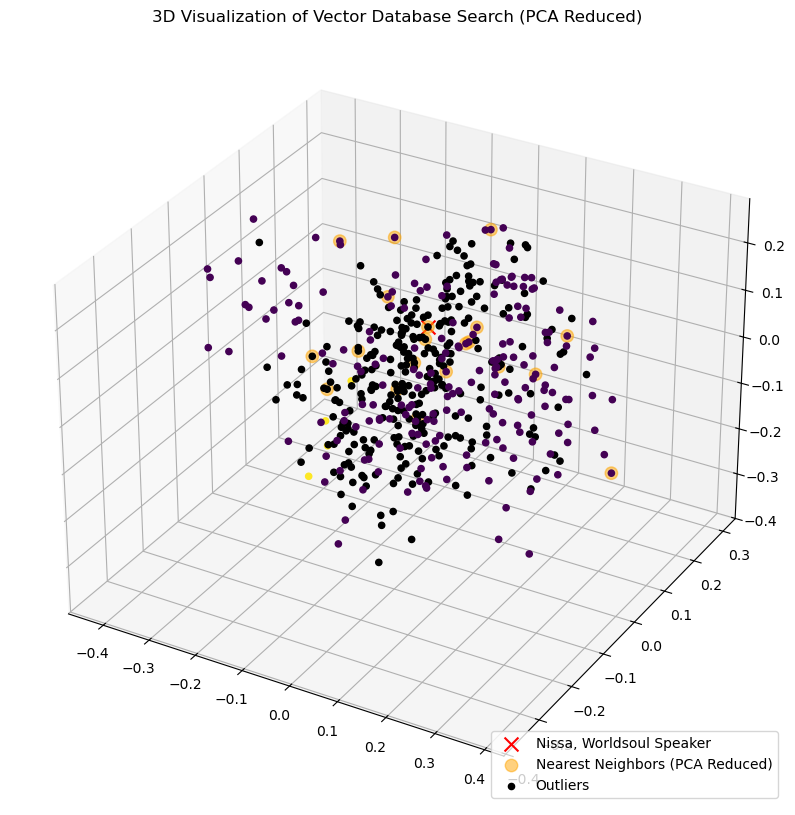

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import hdbscan
import faiss
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

num_random = 1000
random_samp = [0]
possible_indices = np.arange(1, embeddings.shape[0])
random_indices = np.random.choice(possible_indices, size=num_random, replace=False)
random_samp.extend(random_indices)

r_embeddings = embeddings[random_samp]


r_embeddings = embeddings[:500]

index_flat = faiss.IndexFlatL2(r_embeddings.shape[1])
index_flat.add(r_embeddings)

res = faiss.StandardGpuResources()
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)

query_index = 0  
query_vector_original = r_embeddings[query_index].reshape(1, -1)

#knn
k = 20  
distances, indices = gpu_index_flat.search(query_vector_original, k)
nearest_neighbor_vectors_original = r_embeddings[indices[0]]

# Apply PCA for Dimensionality Reduction to 3D
n_components = 3
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(r_embeddings)
reduced_query_vector = pca.transform(query_vector_original)[0]
reduced_nearest_neighbors = pca.transform(nearest_neighbor_vectors_original)

#HDBScan
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
clusters = clusterer.fit_predict(reduced_embeddings)
#clusters = clusterer.fit_predict(r_embeddings)

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], color='black', label='Data Points (PCA Reduced)', alpha=0.4)
ax.scatter(reduced_query_vector[0], reduced_query_vector[1], reduced_query_vector[2], color='red', marker='x', s=100, label="Nissa, Worldsoul Speaker")
ax.scatter(reduced_nearest_neighbors[:, 0], reduced_nearest_neighbors[:, 1], reduced_nearest_neighbors[:, 2], color='orange', s=80, label='Nearest Neighbors (PCA Reduced)', alpha=0.5)
unique_clusters = np.unique(clusters)
#for label, color in zip(np.unique(unique_clusters), colors):
#    cluster_mask = (clusters == label)
#    ax.scatter(reduced_embeddings[cluster_mask, 0],
#               reduced_embeddings[cluster_mask, 1],
#               reduced_embeddings[cluster_mask, 2],
#               c=[color],  # Use a list to ensure color is applied correctly
#               marker='o',
#               alpha=1,)
unique_labels = np.unique(clusters)
cmap = plt.cm.viridis
# Plot each cluster
for label in unique_labels:
    cluster_mask = (clusters == label)
    if label == -1:
        # Outliers: make them black
        ax.scatter(reduced_embeddings[cluster_mask, 0],
                   reduced_embeddings[cluster_mask, 1],
                   reduced_embeddings[cluster_mask, 2],
                   c='black',
                   marker='o',
                   alpha=1,
                   label='Outliers')
    else:
        # Cluster members: use the colormap
        # Find the index of the current label in the sorted unique labels (excluding -1)
        sorted_labels = np.sort(unique_labels[unique_labels != -1])
        if len(sorted_labels) > 0:
            color_index = np.where(sorted_labels == label)[0][0]
            color = cmap(color_index / (len(sorted_labels) - 1) if len(sorted_labels) > 1 else cmap(0))
        else:
            color = cmap(0) # Default color if no clusters other than outliers

        ax.scatter(reduced_embeddings[cluster_mask, 0],
                   reduced_embeddings[cluster_mask, 1],
                   reduced_embeddings[cluster_mask, 2],
                   c=[color],
                   marker='o',
                   alpha=1
                   )
ax.set_title('3D Visualization of Vector Database Search (PCA Reduced)')
ax.legend(loc='lower right')

# Annotate the nearest neighbors (optional)
#for i, neighbor in enumerate(reduced_nearest_neighbors):
#    ax.text(neighbor[0], neighbor[1], neighbor[2], f'NN {i+1}', fontsize=9)

# Show the plot
plt.show()